In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


In [10]:
data = load_breast_cancer()

X = data.data
y = data.target
feature_names = data.feature_names


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
def compute_hsic_kernel(X_feature, y, kernel_type="rbf"):
    X_feature = X_feature.reshape(-1, 1)
    y = y.reshape(-1, 1)
    n = X_feature.shape[0]

    if kernel_type == "linear":
        Kx = linear_kernel(X_feature)
        Ky = linear_kernel(y)
    elif kernel_type == "poly":
        Kx = polynomial_kernel(X_feature, degree=3)
        Ky = polynomial_kernel(y, degree=3)
    elif kernel_type == "rbf":
        Kx = rbf_kernel(X_feature, gamma=0.5)
        Ky = rbf_kernel(y, gamma=0.5)

    H = np.eye(n) - (1/n) * np.ones((n, n))
    hsic = np.trace(Kx @ H @ Ky @ H) / ((n - 1) ** 2)
    return hsic


In [13]:
kernels = ["linear", "poly", "rbf"]
selected_features = {}

for kernel in kernels:
    scores = []
    for i in range(X_scaled.shape[1]):
        score = compute_hsic_kernel(X_scaled[:, i], y, kernel)
        scores.append(score)

    df_scores = pd.DataFrame({
        "Feature": feature_names,
        "HSIC Score": scores
    }).sort_values(by="HSIC Score", ascending=False)

    selected_features[kernel] = df_scores.head(10)["Feature"].values


In [14]:
roc_results = {}

for kernel in kernels:
    feature_mask = [f in selected_features[kernel] for f in feature_names]
    X_selected = X_scaled[:, feature_mask]

    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.3, random_state=42
    )

    model = LogisticRegression(max_iter=500)
    model.fit(X_train, y_train)

    y_scores = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    roc_results[kernel] = (fpr, tpr, roc_auc)


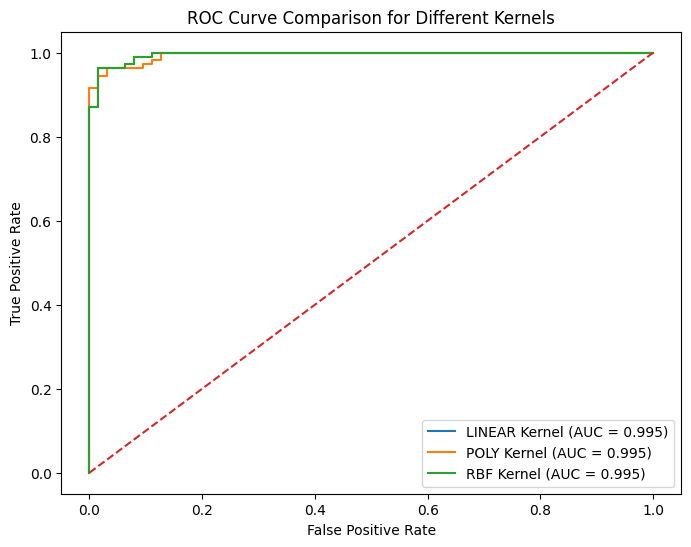

In [15]:
plt.figure(figsize=(8, 6))

for kernel in kernels:
    fpr, tpr, roc_auc = roc_results[kernel]
    plt.plot(fpr, tpr, label=f"{kernel.upper()} Kernel (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Different Kernels")
plt.legend()
plt.show()
